### Load libs

In [1]:
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import numpy as np


In [2]:
n = 500
pd.set_option('display.max_columns', n)
pd.set_option('display.max_rows', n)
pd.set_option('display.max_colwidth', -1)

/anaconda3/envs/kn/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


### Load data

In [3]:
term = 'AmeriCredit Automobile Receivables Trust 2017-1 Data Tape'
folder = 'data/static/'
file = '{} static.csv'.format(term)
path = folder + file
path

'data/static/AmeriCredit Automobile Receivables Trust 2017-1 Data Tape static.csv'

In [4]:
df = pd.read_csv(path)

In [5]:
#df[df['remainingTerm'].isnull()]

In [6]:
#df[['remainingTerm', 'originalLoanTermLoc', 'remainingTermToMaturityNumberMin', 'accountStatus']]

### Processing

In [7]:
def get_term(row, accountStatus, remainingTerm, originalLoanTermLoc, remainingTermToMaturityNumberMin):
    
    """
    Get final term
    """
    
    act = row[accountStatus]
    rt = row[remainingTerm]
    ot = row[originalLoanTermLoc]
    rtm = row[remainingTermToMaturityNumberMin]
    
    if act in ['Charged-off', 'Prepaid or Matured']:
        if rt >= 0:
            res = ot - rt
        else:
            res = ot - rt
    else:
        res = ot - rtm
    
    return res
    

In [43]:
df['finalTerm'] = df.apply(get_term, args = ('accountStatus', 'remainingTerm', 'originalLoanTermLoc', 'remainingTermToMaturityNumberMin', ), axis = 1)  
df['finalTerm'].fillna(0, inplace = True)
df['obligorCreditScoreMax'].replace('None', np.nan, inplace = True)

cols = ['finalTerm', 'currentDelinquencyStatusMax', 'obligorCreditScoreMax']
for col in cols:
    df[col].fillna(0, inplace = True)

df['obligorCreditScoreMax'] = df['obligorCreditScoreMax'].astype(float)


In [45]:
# df[['remainingTerm', 'originalLoanTermLoc', 'remainingTermToMaturityNumberMin', 'accountStatus', 'finalTerm']].head(100)   



### Samples

In [70]:
df['default'] = df['accountStatus'].apply(lambda x: 1 if x == 'Charged-off' else 0)


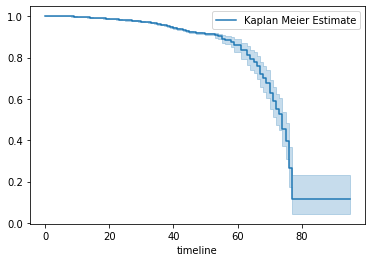

In [71]:
durations = df['finalTerm']
event_observed = df['default'] 

km = KaplanMeierFitter() 
km.fit(durations, event_observed, label='Kaplan Meier Estimate')

km.plot()


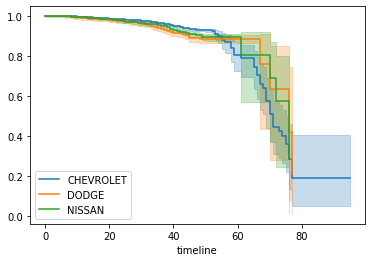

In [72]:
kmf = KaplanMeierFitter() 
T = df['finalTerm']
E = df['default']

groups = df['vehicleManufacturerNameLoc']
ix1 = (groups == 'CHEVROLET')
ix2 = (groups == 'DODGE')
ix3 = (groups == 'NISSAN')

kmf.fit(T[ix1], E[ix1], label='CHEVROLET')
ax = kmf.plot()

kmf.fit(T[ix2], E[ix2], label='DODGE')
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='NISSAN')
kmf.plot(ax=ax1)   

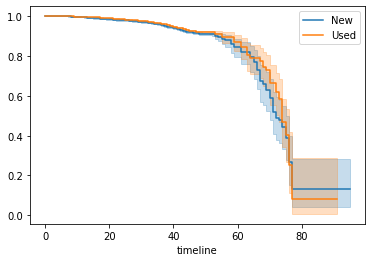

In [73]:
kmf1 = KaplanMeierFitter() 

groups = df['vehicleNewUsedCodeMLoc']   
i1 = (groups == 'New') 
i2 = (groups == 'Used')

kmf1.fit(T[i1], E[i1], label='New')
a1 = kmf1.plot()

kmf1.fit(T[i2], E[i2], label='Used')
kmf1.plot(ax=a1)

### Build regression

In [74]:
# model cols
select_cols = ['finalTerm', 'default', 'originalInterestRatePercentageLoc', 'vehicleValueAmountLoc', 'obligorCreditScoreMax', 'paymentToIncomePercentageLoc', 'vehicleTypeCodeMLoc', 'obligorIncomeVerificationLevelCodeMLoc', 'coObligorIndicatorLoc']        


In [75]:
df_r = df[select_cols]
df_r.head()

,finalTerm,default,originalInterestRatePercentageLoc,vehicleValueAmountLoc,obligorCreditScoreMax,paymentToIncomePercentageLoc,vehicleTypeCodeMLoc,obligorIncomeVerificationLevelCodeMLoc,coObligorIndicatorLoc
0,56.0,1,0.0890,24412.0,552.0,0.0688,Car,"Stated, not verified",True
1,70.0,1,0.1449,19225.0,561.0,0.0924,Truck,"Stated, not verified",False
2,75.0,0,0.1090,23472.0,562.0,0.0819,Car,"Stated, not verified",True
3,75.0,0,0.1095,28252.0,536.0,0.0781,SUV,"Stated, not verified",True
4,75.0,0,0.1090,24821.0,536.0,0.1186,Car,"Stated, not verified",False


In [78]:
df_dummy = pd.get_dummies(df_r, drop_first=True)
df_dummy.shape

(20020, 11)

In [79]:
# proportional hazard model
cph = CoxPHFitter()
cph.fit(df_dummy, 'finalTerm', event_col='default')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 20020 total observations, 18375 right-censored observations>
             duration col = 'finalTerm'
                event col = 'default'
      baseline estimation = breslow
   number of observations = 20020
number of events observed = 1645
   partial log-likelihood = -15483.40
         time fit was run = 2021-01-26 22:24:19 UTC

---
                                                                                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                                                     
originalInterestRatePercentageLoc                                                       9.46   12820.60       0.72             8.06            10.86              3149.91             52181.75
vehicleValueAmountLoc                                                                   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
obligorCreditScoreMax                                                                   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
paymentToIncomePercentageLoc                                                            2.62      13.72       0.73             1.20             4.04                 3.30                57.01
coObligorIndicatorLoc                                                                   0.15       1.16       0.05             0.04             0.26                 1.04                 1.29
vehicleTypeCodeMLoc_SUV                                                                -0.15       0.86       0.06            -0.26            -0.04                 0.77                 0.96
vehicleTypeCodeMLoc_Truck                                                              -0.26       0.77       0.09            -0.44            -0.09                 0.65                 0.91
vehicleTypeCodeMLoc_Unknown                                                           -10.95       0.00     391.31          -777.89           756.00                 0.00                  inf
obligorIncomeVerificationLevelCodeMLoc_Stated, verified but not to level 4 or level 5   0.29       1.34       0.07             0.15             0.44                 1.16                 1.55

                                                                                          z      p   -log2(p)
covariate                                                                                                    
originalInterestRatePercentageLoc                                                     13.21 <0.005     129.89
vehicleValueAmountLoc                                                                  6.65 <0.005      35.02
obligorCreditScoreMax                                                                  0.36   0.72       0.48
paymentToIncomePercentageLoc                                                           3.61 <0.005      11.65
coObligorIndicatorLoc                                                                  2.77   0.01       7.46
vehicleTypeCodeMLoc_SUV                                                               -2.60   0.01       6.76
vehicleTypeCodeMLoc_Truck                                                             -2.97 <0.005       8.41
vehicleTypeCodeMLoc_Unknown                                                           -0.03   0.98       0.03
obligorIncomeVerificationLevelCodeMLoc_Stated, verified but not to level 4 or level 5  4.02 <0.005      14.05
---
Concordance = 0.64
Partial AIC = 30984.80
log-likelihood ratio test = 349.45 on 9 df
-log2(p) of ll-ratio test = 229.51

In [80]:
tr_rows = df_dummy.iloc[0:10]

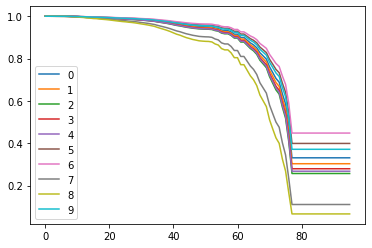

In [81]:
cph.predict_survival_function(tr_rows).plot()


In [82]:
preds = cph.predict_survival_function(df_dummy).T


In [87]:
final = pd.concat([df, preds], axis = 1)

In [88]:
final

,ID,records,accountStatus,remainingTerm,originatorNameLoc,primaryLoanServicerNameLoc,originationDateRLoc,originalLoanAmountLoc,originalLoanTermLoc,loanMaturityDateRLoc,originalInterestRatePercentageLoc,interestCalculationTypeCodeMLoc,originalInterestRateTypeCodeMLoc,originalInterestOnlyTermNumberLoc,originalFirstPaymentDateRLoc,underwritingIndicatorLoc,paymentTypeCodeMLoc,vehicleManufacturerNameLoc,vehicleModelNameLoc,vehicleNewUsedCodeMLoc,vehicleModelYearLoc,vehicleTypeCodeMLoc,vehicleValueAmountLoc,vehicleValueSourceCodeMLoc,obligorCreditScoreTypeLoc,obligorIncomeVerificationLevelCodeMLoc,obligorEmploymentVerificationCodeMLoc,coObligorIndicatorLoc,paymentToIncomePercentageLoc,obligorGeographicLocationLoc,assetAddedIndicatorLoc,reportingPeriodModificationIndicatorLoc,servicingAdvanceMethodCodeMLoc,reportingPeriodBeginningLoanBalanceAmountLoc,nextReportingPeriodPaymentAmountDueLoc,reportingPeriodInterestRatePercentageLoc,nextInterestRatePercentageLoc,scheduledInterestAmountLoc,otherPrincipalAdjustmentAmountLoc,reportingPeriodActualEndBalanceAmountLoc,reportingPeriodScheduledPaymentAmountLoc,assetSubjectDemandIndicatorLoc,zeroBalanceEffectiveDateRLoc,reportingPeriodBeginningDateRMin,reportingPeriodBeginningDateRMax,reportingPeriodEndingDateRMin,reportingPeriodEndingDateRMax,remainingTermToMaturityNumberMin,remainingTermToMaturityNumberMax,currentDelinquencyStatusMin,currentDelinquencyStatusMax,obligorCreditScoreMin,obligorCreditScoreMax,gracePeriodNumberMax,interestPaidThroughDateRMax,mostRecentServicingTransferReceivedDateRMax,chargedoffPrincipalAmountMax,recoveredAmountMax,paymentExtendedNumberMax,repossessedProceedsAmountMax,subventedMVals,assetSubjectDemandIndicatorVals,assetSubjectDemandStatusCodeMVals,repurchaserNameVals,repurchaseReplacementReasonCodeMVals,modificationTypeCodeMVals,repossessedIndicatorVals,zeroBalanceCodeMVals,accountStatusVals,servicingFeePercentageMean,servicingFlatFeeAmountMean,otherServicerFeeRetainedByServicerMean,otherAssessedUncollectedServicerFeeAmountMean,totalActualAmountPaidSum,actualInterestCollectedAmountSum,actualPrincipalCollectedAmountSum,actualOtherCollectedAmountSum,servicerAdvancedAmountSum,currentDelinquencyStatusSum,repurchaseAmountSum,chargedoffPrincipalAmountSum,recoveredAmountSum,paymentExtendedNumberSum,repossessedProceedsAmountSum,finalTerm,default,0.0,2.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,91.0,95.0
0,0001694010 - 000010,27,Charged-off,18.0,GM FINANCIAL,GM FINANCIAL,2012-03,27746.63,74,2018-12,0.0890,Simple,Fixed,0,2012-05,True,Monthly,CHEVROLET,MALIBU,New,2012,Car,24412.0,Invoice Price,Credit Bureau Score,"Stated, not verified","Stated, not verified",True,0.0688,CA,False,False,No advancing,0.00,0.00,NaN,NaN,0.000000,0.0,0.00,0.00,False,2017-07,2016-12-01,2020-11-01,2016-12-31,2020-11-30,0,24,44.0,107.0,552,552.0,2,2017-04-21,NaN,11927.53,0.00,0,0.0,Yes - Rate Subvention,False,Other,-,Other,Other,False,Charged-off | Unavailable,Charged-off | Unavailable,0.0225,0.0,0.0,46.355185,6750.82,3612.81,3138.01,0.00,0.0,364.0,0.0,9935.89,0.00,0,0.0,56.0,1,0.999972,0.999943,0.999829,0.999687,0.999373,0.999031,0.998632,0.997919,0.997547,0.996719,0.996289,0.995574,0.995316,0.994600,0.994026,0.993510,0.992850,0.992045,0.991240,0.990492,0.989743,0.989224,0.988445,0.987896,0.987087,0.986075,0.985032,0.984046,0.983001,0.981665,0.980384,0.978199,0.976240,0.974365,0.972305,0.969969,0.967229,0.964545,0.962649,0.960069,0.957595,0.955782,0.953803,0.952487,0.951050,0.950420,0.949943,0.949711,0.948688,0.944523,0.942228,0.934780,0.932021,0.932021,0.925610,0.915170,0.915170,0.899667,0.899667,0.887068,0.874181,0.864854,0.850906,0.827334,0.812519,0.797357,0.760764,0.733713,0.706201,0.68851

In [105]:
vals = [.2, .3, .4, .5, .6, .7, .8, .9]

In [113]:
holder = []
for val in vals:
    sub = final[final[77.0] <= val]
    _sum = sub['default'].sum()
    dr = _sum / len(sub)
    
    _dict = {}
    _dict['level'] = val
    _dict['dr'] = dr
    holder.append(_dict)

In [114]:
res = pd.DataFrame(holder)

In [115]:
res

,level,dr
0,0.2,0.105721
1,0.3,0.096240
2,0.4,0.089006
3,0.5,0.084248
4,0.6,0.082394
5,0.7,0.082184
6,0.8,0.082184
7,0.9,0.082184


In [117]:
final[final[70.0] <= .2]

,ID,records,accountStatus,remainingTerm,originatorNameLoc,primaryLoanServicerNameLoc,originationDateRLoc,originalLoanAmountLoc,originalLoanTermLoc,loanMaturityDateRLoc,originalInterestRatePercentageLoc,interestCalculationTypeCodeMLoc,originalInterestRateTypeCodeMLoc,originalInterestOnlyTermNumberLoc,originalFirstPaymentDateRLoc,underwritingIndicatorLoc,paymentTypeCodeMLoc,vehicleManufacturerNameLoc,vehicleModelNameLoc,vehicleNewUsedCodeMLoc,vehicleModelYearLoc,vehicleTypeCodeMLoc,vehicleValueAmountLoc,vehicleValueSourceCodeMLoc,obligorCreditScoreTypeLoc,obligorIncomeVerificationLevelCodeMLoc,obligorEmploymentVerificationCodeMLoc,coObligorIndicatorLoc,paymentToIncomePercentageLoc,obligorGeographicLocationLoc,assetAddedIndicatorLoc,reportingPeriodModificationIndicatorLoc,servicingAdvanceMethodCodeMLoc,reportingPeriodBeginningLoanBalanceAmountLoc,nextReportingPeriodPaymentAmountDueLoc,reportingPeriodInterestRatePercentageLoc,nextInterestRatePercentageLoc,scheduledInterestAmountLoc,otherPrincipalAdjustmentAmountLoc,reportingPeriodActualEndBalanceAmountLoc,reportingPeriodScheduledPaymentAmountLoc,assetSubjectDemandIndicatorLoc,zeroBalanceEffectiveDateRLoc,reportingPeriodBeginningDateRMin,reportingPeriodBeginningDateRMax,reportingPeriodEndingDateRMin,reportingPeriodEndingDateRMax,remainingTermToMaturityNumberMin,remainingTermToMaturityNumberMax,currentDelinquencyStatusMin,currentDelinquencyStatusMax,obligorCreditScoreMin,obligorCreditScoreMax,gracePeriodNumberMax,interestPaidThroughDateRMax,mostRecentServicingTransferReceivedDateRMax,chargedoffPrincipalAmountMax,recoveredAmountMax,paymentExtendedNumberMax,repossessedProceedsAmountMax,subventedMVals,assetSubjectDemandIndicatorVals,assetSubjectDemandStatusCodeMVals,repurchaserNameVals,repurchaseReplacementReasonCodeMVals,modificationTypeCodeMVals,repossessedIndicatorVals,zeroBalanceCodeMVals,accountStatusVals,servicingFeePercentageMean,servicingFlatFeeAmountMean,otherServicerFeeRetainedByServicerMean,otherAssessedUncollectedServicerFeeAmountMean,totalActualAmountPaidSum,actualInterestCollectedAmountSum,actualPrincipalCollectedAmountSum,actualOtherCollectedAmountSum,servicerAdvancedAmountSum,currentDelinquencyStatusSum,repurchaseAmountSum,chargedoffPrincipalAmountSum,recoveredAmountSum,paymentExtendedNumberSum,repossessedProceedsAmountSum,finalTerm,default,0.0,2.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0,34.0,35.0,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0,46.0,47.0,48.0,49.0,50.0,51.0,52.0,53.0,54.0,55.0,56.0,57.0,58.0,59.0,60.0,61.0,62.0,63.0,64.0,65.0,66.0,67.0,68.0,69.0,70.0,71.0,72.0,73.0,74.0,75.0,76.0,77.0,91.0,95.0
3298,0001694010 - 017338,47,Unavailable,NaN,GM FINANCIAL,GM FINANCIAL,2016-09,15239.94,73,2023-05,0.2499,Simple,Fixed,0,2016-10,True,Monthly,FORD,FUSION,Used,2014,Car,15600.0,Other,Credit Bureau Score,"Stated, verified but not to level 4 or level 5","Stated, level 3 verified",True,0.1236,OH,False,False,No advancing,12829.88,820.86,0.2499,0.2499,154.947656,0.0,12797.80,410.43,False,NaN,2016-12-01,2020-11-01,2016-12-31,2020-11-30,30,69,0.0,74.0,590,590.0,1,2020-11-30,NaN,0.00,0.0,2,0.0,No,False,Other,-,Other,Other | Extension,False,Unavailable,Unavailable,0.0225,0.0,0.0,210.373617,16171.09,13869.80,2280.77,20.52,0.0,1071.0,0.0,0.00,0.00,8,0.0,43.0,0,0.999829,0.999658,0.998974,0.998120,0.996243,0.994198,0.991815,0.987570,0.985366,0.980463,0.977932,0.973723,0.972210,0.968018,0.964673,0.961668,0.957838,0.953189,0.948555,0.944265,0.939986,0.937030,0.932610,0.929506,0.924945,0.919267,0.913448,0.907975,0.902202,0.894864,0.887879,0.876063,0.865588,0.855652,0.844853,0.832740,0.818718,0.805174,0.795721,0.783006,0.770970,0.762248,0.752826,0.746611,0.739874,0.736939,0.734720,0.733644,0.728911,0.709913,0.699619,0.667074,0.655343,0.655343,0.628742,0.587358,0.587358,0.530103,0.530103,0.487074,0.446112,0.418290,0.379394,0.320517,0.287572,0.256825,0.193716,0.155875,0.123921,0.106423,0

In [78]:
print('continue...')

continue...


### End